In [42]:
source("./Functions/MOCL.R") 
source("./Functions/lambda_selection.R")
source("./Functions/MOCL_wcss.R")
source("./Functions/Adaptive_MAM.R") 

source("./Functions/SKM_gap.R")
source("./Functions/evaluation.R")

library(VarSelLCM) # VarselLCM
library(cluster)     # PAM

library(ggplot2)
library(gridExtra)
library(ggpubr)
library(ggthemes)
library(GGally)
library(RColorBrewer)
library(corrplot)
library(dplyr)
library(pdfCluster)
library(fossil)
options(warn=-1)
library(Rtsne)
library(latex2exp)

In [2]:
library(ggplot2)
dia_data=diamonds
head(dia_data)

carat,cut,color,clarity,depth,table,price,x,y,z
<dbl>,<ord>,<ord>,<ord>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
0.23,Ideal,E,SI2,61.5,55,326,3.95,3.98,2.43
0.21,Premium,E,SI1,59.8,61,326,3.89,3.84,2.31
0.23,Good,E,VS1,56.9,65,327,4.05,4.07,2.31
0.29,Premium,I,VS2,62.4,58,334,4.20,4.23,2.63
0.31,Good,J,SI2,63.3,58,335,4.34,4.35,2.75
0.24,Very Good,J,VVS2,62.8,57,336,3.94,3.96,2.48


## Preprocessing

In [3]:
colnames(dia_data)=c('carat','cut','color','clarity','depth','table','price',"length","width","height")

data_x=dia_data[,-7]
price=dia_data[,7]

# Ordinal data labeling
data_x[,2]=(data_x[,2]=="Fair")*1+(data_x[,2]=="Good")*2+(data_x[,2]=="Very Good")*3+
(data_x[,2]=="Premium")*4+(data_x[,2]=="Ideal")*5

data_x[,3]=(data_x[,3]=="D")*1+(data_x[,3]=="E")*2+(data_x[,3]=="F")*3+(data_x[,3]=="G")*4+(data_x[,3]=="H")*5+
(data_x[,3]=="I")*6+(data_x[,3]=="J")*7

data_x[,4]=(data_x[,4]=='I1')*2+(data_x[,4]=='SI1')*3+(data_x[,4]=='SI2')*4+(data_x[,4]=='VS1')*5+
(data_x[,4]=='VS2')*6+(data_x[,4]=='VVS1')*7+(data_x[,4]=='VVS2')*8+(data_x[,4]=='IF')*9-1

data_x=as.matrix(data_x)
data_x=as.data.frame(data_x)

## Sampling

In [4]:
set.seed(13)
sam=sample(1:nrow(data_x),5000)

sub_x=scale(data_x[sam,])
sub_price=t(price[sam,])
y=sub_price

# Clustering

In [5]:
kk=5

In [6]:
a=Sys.time()
pam <- pam(sub_x,kk)
cat("PAM time :",Sys.time()-a)

a=Sys.time()
km <- KMeans_rcpp(sub_x,kk)
print("======================")
cat("KMpp time :",Sys.time()-a)

PAM time : 4.413098[1] "======================"
KMpp time : 0.02511501

In [7]:
a=Sys.time()
varsel <- VarSelCluster(sub_x, kk, nbcores = 1, crit.varsel = 'BIC') 
cat("VSL time :")
Sys.time()-a

VSL time :

Time difference of 1.684443 mins

In [8]:
Sys.time()
a=Sys.time()
mocl <- MOCL_wcss(Xf=sub_x,k=kk,lambda_seq=seq.default(from=0.001,to=3,length=100),delta=0.01)
Sys.time()-a

[1] "2024-08-05 21:56:24 KST"

Time difference of 1.15728 mins

In [9]:
a=Sys.time()
skm <- Sparse_km(data=sub_x,kk=kk,nperms_n=10)
Sys.time()-a

012345
01234


Time difference of 1.585484 mins

# Results

In [25]:
clu_mocl=(kk+1)-mocl$cluster
clu_skm=skm$cluster_1sd # clu_skm_1sd=skm$cluster_1sd
clu_vsl=fitted(varsel)
clu_km=km$cluster
clu_pam=pam$cluster

In [26]:
sparse_mat=rbind(t(matrix(apply(abs(mocl$fx),2,sum)>0)), 
                 skm$sparse_1sd,slot(slot(varsel,'model'),'omega'))

rownames(sparse_mat)=c("MOCL","SKM","VSL")
sparse_mat

,carat,cut,color,clarity,depth,table,length,width,height
MOCL,1,1,0,0,0,0,0,1,1
SKM,1,1,1,1,0,1,1,1,1
VSL,1,1,1,1,1,1,1,1,1


## t-SNE

## Sampling for t-SNE

In [27]:
set.seed(141)
tsne<-Rtsne(sub_x,dim=2,perplexity=30, verbose=TRUE, max_iter = 500,check_duplicates = FALSE)

Performing PCA
Read the 5000 x 9 data matrix successfully!
Using no_dims = 2, perplexity = 30.000000, and theta = 0.500000
Computing input similarities...
Building tree...
Done in 0.32 seconds (sparsity = 0.023707)!
Learning embedding...
Iteration 50: error is 89.884462 (50 iterations in 0.35 seconds)
Iteration 100: error is 79.757254 (50 iterations in 0.41 seconds)
Iteration 150: error is 79.443991 (50 iterations in 0.35 seconds)
Iteration 200: error is 79.435243 (50 iterations in 0.36 seconds)
Iteration 250: error is 79.433761 (50 iterations in 0.36 seconds)
Iteration 300: error is 2.454821 (50 iterations in 0.32 seconds)
Iteration 350: error is 2.057090 (50 iterations in 0.32 seconds)
Iteration 400: error is 1.853410 (50 iterations in 0.32 seconds)
Iteration 450: error is 1.730204 (50 iterations in 0.32 seconds)
Iteration 500: error is 1.649811 (50 iterations in 0.32 seconds)
Fitting performed in 3.43 seconds.


In [28]:
set.seed(89)
#set.seed(99)
tsne_sam=sample(1:nrow(sub_x),500)

lab_mocl=as.factor(clu_mocl[tsne_sam])
lab_skm=as.factor(clu_skm[tsne_sam])
lab_vsl=as.factor(clu_vsl[tsne_sam])
lab_km=as.factor(clu_km[tsne_sam])
lab_pam=as.factor(clu_pam[tsne_sam])


tsne_y=tsne$Y[tsne_sam,]

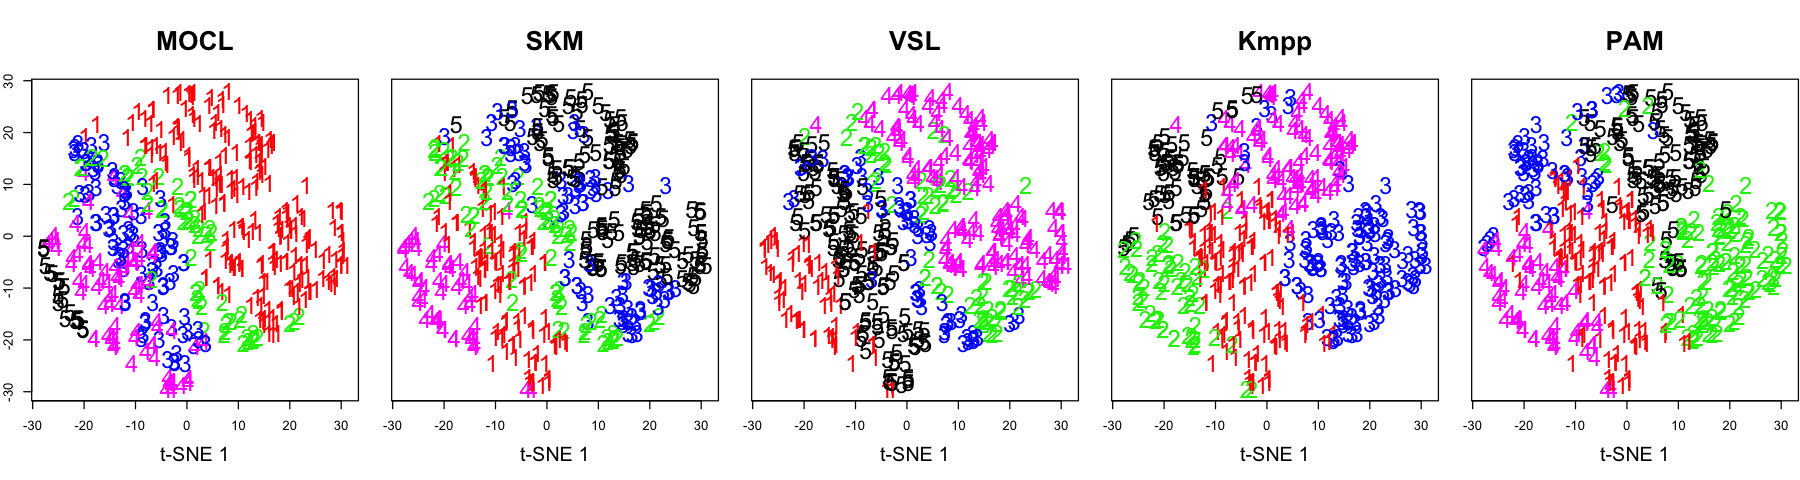

In [29]:
options(repr.plot.width = 15, repr.plot.height = 4)
par(mfrow=c(1,5))
par(mar=c(5,2,5,0.1))
#par(mar=c(5,3,5,3))
colors=c("red","green 2","Blue","Magenta","black")


pchs=c(0,2,3,4,5,1)
names(colors) = c(1:kk)

################################
plot(tsne_y,t='n',col=lab_mocl,pch=19,main="MOCL",cex.main=2,
     xlab="t-SNE 1",ylab="t-SNE 2",cex.lab=1.5,cex.axis=1)
text(tsne_y, labels=lab_mocl, col=colors[lab_mocl],cex=1.8)


plot(tsne_y,t='n',col=lab_skm,pch=19,main="SKM",cex.main=2,
     xlab="t-SNE 1",ylab="",cex.lab=1.6,yaxt="n",cex.lab=1.5,cex.axis=1)
text(tsne_y, labels=lab_skm, col=colors[lab_skm],cex=1.8)
plot(tsne_y,t='n',col=lab_vsl,pch=19,main="VSL",cex.main=2,
     xlab="t-SNE 1",ylab="",cex.lab=1.6,yaxt="n",cex.lab=1.5,cex.axis=1)
text(tsne_y, labels=lab_vsl, col=colors[lab_vsl],cex=1.8)
plot(tsne_y,t='n',col=lab_km,pch=19,main="Kmpp",cex.main=2,
     xlab="t-SNE 1",ylab="",cex.lab=1.6,yaxt="n",cex.lab=1.5,cex.axis=1)
text(tsne_y, labels=lab_km, col=colors[lab_km],cex=1.8)
plot(tsne_y,t='n',col=lab_pam,pch=19,main="PAM",cex.main=2,
     xlab="t-SNE 1",ylab="",cex.lab=1.6,yaxt="n",cex.lab=1.5,cex.axis=1)
text(tsne_y, labels=lab_pam, col=colors[lab_pam],cex=1.8)

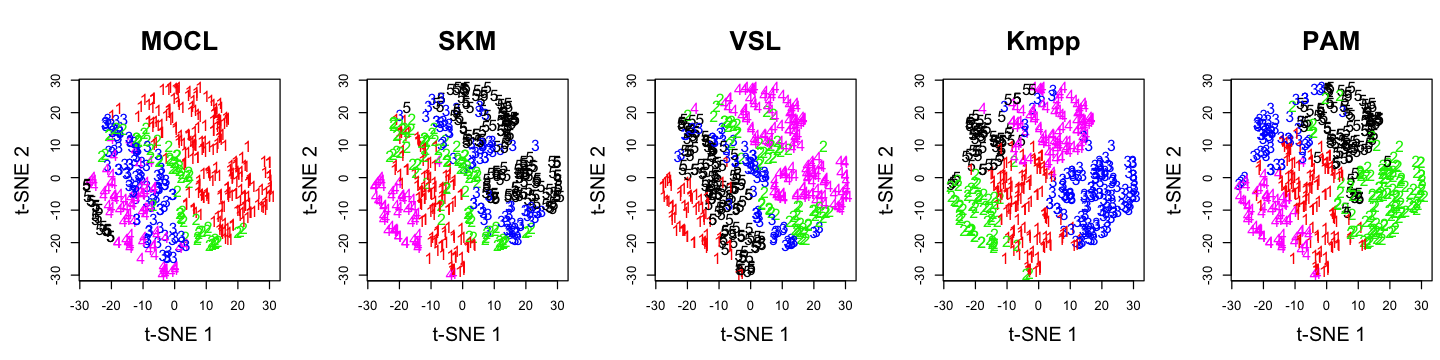

In [30]:
options(repr.plot.width = 12, repr.plot.height = 3)
par(mfrow=c(1,5))
par(mar=c(5,5,5,0.5))
#par(mar=c(5,3,5,3))
colors=c("red","green 2","Blue","Magenta","black")


pchs=c(0,2,3,4,5,1)
names(colors) = c(1:kk)

################################
plot(tsne_y,t='n',col=lab_mocl,pch=19,main="MOCL",cex.main=2,xlab="t-SNE 1",ylab="t-SNE 2",cex.lab=1.5)
text(tsne_y, labels=lab_mocl, col=colors[lab_mocl],cex=1.2)
plot(tsne_y,t='n',col=lab_skm,pch=19,main="SKM",cex.main=2,xlab="t-SNE 1",ylab="t-SNE 2",cex.lab=1.5)
text(tsne_y, labels=lab_skm, col=colors[lab_skm],cex=1.2)
plot(tsne_y,t='n',col=lab_vsl,pch=19,main="VSL",cex.main=2,xlab="t-SNE 1",ylab="t-SNE 2",cex.lab=1.5)
text(tsne_y, labels=lab_vsl, col=colors[lab_vsl],cex=1.2)
plot(tsne_y,t='n',col=lab_km,pch=19,main="Kmpp",cex.main=2,xlab="t-SNE 1",ylab="t-SNE 2",cex.lab=1.5)
text(tsne_y, labels=lab_km, col=colors[lab_km],cex=1.2)
plot(tsne_y,t='n',col=lab_pam,pch=19,main="PAM",cex.main=2,xlab="t-SNE 1",ylab="t-SNE 2",cex.lab=1.5)
text(tsne_y, labels=lab_pam, col=colors[lab_pam],cex=1.2)

## Estimated functions

In [31]:
col_lst=c("red","Magenta","Brown","Cyan","Dark Magenta","grey",
          "Orange","Blue","Lime Green")

In [35]:
dd=nor_minmax(sub_x)

In [36]:
dd_mo=dd[,sparse_mat[1,]>0]
col_mo=col_lst[sparse_mat[1,]>0]


In [37]:
fx_mo=-mocl$fx[,sparse_mat[1,]>0]

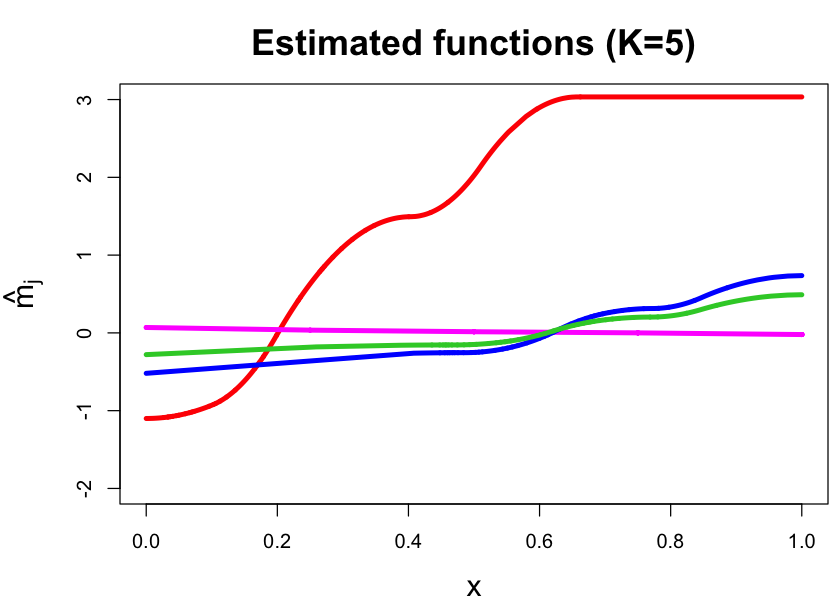

In [38]:
options(repr.plot.width = 7, repr.plot.height = 5)
par(mar=c(4,5,3.5,0.5))
for(i in 1:ncol(dd_mo)){
    o_i=order(dd_mo[,i])
    if(i==1){
        plot(dd_mo[o_i,i],fx_mo[o_i,i],col=col_mo[i],type="l",
             lwd=4,ylim=c(-2,3),xlim=c(0,1),main="Estimated functions (K=5)",
            xlab=TeX("$x$"),ylab=TeX("$\\hat{m}_j$"),cex.main=1.8,cex.lab=1.5)
    }else{lines(dd_mo[o_i,i],fx_mo[o_i,i],col=col_mo[i],lwd=4)}
}



In [39]:
rand.index(clu_mocl,clu_skm)
rand.index(clu_mocl,clu_vsl)


[1] 0.8284348

[1] 0.8647397

In [40]:
cor(clu_mocl,c(y),method="spearman")

[1] 0.9180826

## Save

In [41]:
cluster_mat=cbind(clu_mocl,clu_skm,clu_vsl,clu_km,clu_pam)
colnames(cluster_mat)=c("MOCL","SKM","VSL","Kmpp","PAM")

dia_lst=list()


dia_lst[["X"]]=sub_x
dia_lst[["y"]]=c(y)
dia_lst[["cluster_mat"]]=cluster_mat
dia_lst[["var_sel"]]=sparse_mat
dia_lst[["mocl"]]=mocl
#dia_lst[["fx_mslasso"]]=function_mat
###############################
###############################
# Save
saveRDS(dia_lst,file="Dia_K5.RData")